Things to do(optional but encouraged):
<br>Denote every line and explain the meaning
<br>Explore CNN works, research more from textbooks etc.

Designing your own search operators.<br>
Customise yr own simulated annealing.<br>
Metaheuristics to be used: Tabu Search, Genetic Algorithm and Simulated Annealing<br>
Grid search : python loop for metaheuristics hyperparameters - simulated annealing.

Evaluation Phase <br>
Perform cross validation -  average performance on all cross validation runs for all metaheuristics. 10 times. K-Fold Cross Validation <br>
Compare with Traditional Methods of hyperparameter tuning - Exhaustive Search, Bayesian optimisation(might be too complex), Random Sampling

In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow
print("Num GPUs Available:", len(tensorflow.config.list_physical_devices('GPU')))
from tensorflow.keras.utils import to_categorical
import random

Num GPUs Available: 1


1. Resize all images to 32×32

2. Normalize pixel values to [0, 1]

3. One-hot encode labels

4. Split into training and validation/test sets

In [2]:
def load_gtsrb_data(root_path):
    from PIL import Image
    import numpy as np
    import os
    from glob import glob

    images = []
    labels = []

    for class_id in range(43):
        class_path = os.path.join(root_path, format(class_id, '05d'))
        image_files = glob(os.path.join(class_path, '*.ppm'))
        for file_path in image_files:
            with Image.open(file_path) as img:
                img = img.resize((32, 32))
                images.append(np.array(img))
                labels.append(class_id)

    return np.array(images), np.array(labels)


X ,y = load_gtsrb_data("GTSRB/Training")
X = X.astype("float32")/255.0
y = to_categorical(y, num_classes =43)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# def load_gtsrb_data(root_path):
#     images = []
#     labels = []
#     for class_id in range(43):
#         class_path =os.path.join(root_path, format(class_id,'05d'))
#         for img_name in os.listdir(class_path):
#             if img_name.endswith(".ppm"):
#                 img = Image.open(os.path.join(class_path, img_name)).resize((32,32))
#                 images.append(np.array(img))
#                 labels.append(class_id)
#     return np.array(images), np.array(labels)

# X ,y = load_gtsrb_data("GTSRB/Training")
# X = X.astype("float32")/255.0
# y = to_categorical(y, num_classes =43)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                                           

# Step 2: Define CNN Configuration Encoding
Metaheuristics need to search over a space of candidate solutions, and each CNN configuration is a “solution”.

What to Encode:
Hyperparameter	Example Values
Filters	[32, 64, 128]
Kernel size	[3, 5]
Dropout	[0.3, 0.5]
Dense units	[64, 128, 256]
Optimizer	['adam', 'sgd']
Learning rate	[0.01, 0.001, 0.0001]

In [4]:
# This is random sampling.
def random_config():
    return {
        'filters': random.choice([32, 64, 128]),
        'kernel_size': random.choice([3, 5]),
        'dropout': random.choice([0.3, 0.5]),
        'dense_units': random.choice([64, 128, 256]),
        'optimizer': random.choice(['adam', 'sgd']),
        'learning_rate': random.choice([0.01, 0.001, 0.0001])
    }


With the above small scale sample, we have about 3* 2 * 2* 3 * 2 * 3 =216 possibilies.
Do note that random.choice means choosing with replacment.

In [5]:
from tensorflow.keras import layers, models, optimizers

def build_and_evaluate(config):
    model = models.Sequential()
    model.add(layers.Conv2D(config['filters'], (config['kernel_size'], config['kernel_size']),
                            activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(config['dropout']))
    model.add(layers.Dense(config['dense_units'], activation='relu'))
    model.add(layers.Dense(43, activation='softmax'))  # GTSRB has 43 classes

    if config['optimizer'] == 'adam':
        opt = optimizers.Adam(learning_rate=config['learning_rate'])
    else:
        opt = optimizers.SGD(learning_rate=config['learning_rate'])

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=5, batch_size=128, verbose=0)  # Short training for speed
    _, acc = model.evaluate(X_test, y_test, verbose=0)
    return acc


In [6]:
best_score = 0
best_config = None
best_over_time = []          # Track best-so-far accuracy
accuracy_over_time = []      # Track current trial accuracy

for i in range(50):  # 50 random samples
    config = random_config()
    acc = build_and_evaluate(config)
    
    accuracy_over_time.append(acc)
    
    if acc > best_score:
        best_score = acc
        best_config = config

    best_over_time.append(best_score)  # Always append current best

    print(f"Trial {i+1}: Accuracy = {acc:.4f} | Best = {best_score:.4f} | Config = {config}")

print("\nBest Random Config:")
print(best_config)
print(f"Best Accuracy: {best_score:.4f}")

Trial 1: Accuracy = 0.5704 | Best = 0.5704 | Config = {'filters': 128, 'kernel_size': 5, 'dropout': 0.3, 'dense_units': 128, 'optimizer': 'sgd', 'learning_rate': 0.01}
Trial 2: Accuracy = 0.7046 | Best = 0.7046 | Config = {'filters': 64, 'kernel_size': 5, 'dropout': 0.3, 'dense_units': 64, 'optimizer': 'adam', 'learning_rate': 0.0001}
Trial 3: Accuracy = 0.9687 | Best = 0.9687 | Config = {'filters': 128, 'kernel_size': 5, 'dropout': 0.3, 'dense_units': 64, 'optimizer': 'adam', 'learning_rate': 0.001}
Trial 4: Accuracy = 0.9521 | Best = 0.9687 | Config = {'filters': 32, 'kernel_size': 3, 'dropout': 0.3, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.001}
Trial 5: Accuracy = 0.6928 | Best = 0.9687 | Config = {'filters': 32, 'kernel_size': 5, 'dropout': 0.5, 'dense_units': 64, 'optimizer': 'adam', 'learning_rate': 0.0001}
Trial 6: Accuracy = 0.0816 | Best = 0.9687 | Config = {'filters': 64, 'kernel_size': 5, 'dropout': 0.3, 'dense_units': 64, 'optimizer': 'sgd', 'learning_rat

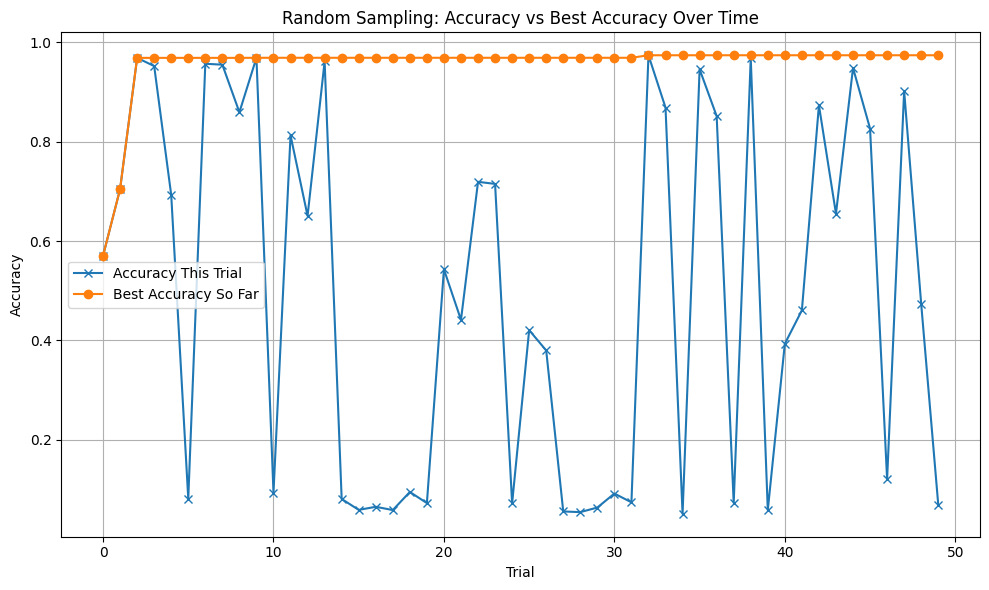

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(accuracy_over_time, label='Accuracy This Trial', marker='x')
plt.plot(best_over_time, label='Best Accuracy So Far', marker='o')
plt.title('Random Sampling: Accuracy vs Best Accuracy Over Time')
plt.xlabel('Trial')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Simulated annealing with the above search space. Small Scale Problem 

In [9]:
import random
from copy import deepcopy

def perturb(config):
    new_config = deepcopy(config)
    key = random.choice(list(config.keys()))
    
    if key == 'filters':
        new_config[key] = random.choice([32, 64, 128])
    elif key == 'kernel_size':
        new_config[key] = random.choice([3, 5])
    elif key == 'dropout':
        new_config[key] = random.choice([0.3, 0.5])
    elif key == 'dense_units':
        new_config[key] = random.choice([64, 128, 256])
    elif key == 'optimizer':
        new_config[key] = random.choice(['adam', 'sgd'])
    elif key == 'learning_rate':
        new_config[key] = random.choice([0.01, 0.001, 0.0001])
    
    return new_config


In [10]:
# Simulated Annealing loop (50 iterations)
def simulated_annealing(iterations=50, T_init=1.0, alpha=0.9):
    current = random_config()
    current_score = build_and_evaluate(current)
    best = current
    best_score = current_score
    T = T_init
    history = []
    accuracy_over_time = []  # NEW
    best_over_time = []

    for i in range(iterations):
        candidate = perturb(current)
        candidate_score = build_and_evaluate(candidate)
        delta = candidate_score - current_score

        # Simulated Annealing acceptance
        if delta > 0 or random.random() < np.exp(delta / T):
            current = candidate
            current_score = candidate_score
            if candidate_score > best_score:
                best = candidate
                best_score = candidate_score

        accuracy_over_time.append(current_score)   # Track current trial accuracy
        best_over_time.append(best_score)          # Track best-so-far accuracy
        history.append({'Trial': i+1, 'Score': current_score, **current})

        print(f"Iter {i+1}: Score = {current_score:.4f}, Best = {best_score:.4f}")
        T *= alpha  # Cooling

    return best, best_score, pd.DataFrame(history), accuracy_over_time, best_over_time

# Run the SA process
best_config, best_acc, df_sa, accuracy_over_time, best_over_time = simulated_annealing()

# Display results
print("\nBest Configuration:")
print(best_config)
print(f"Best Accuracy: {best_acc:.4f}")


best_config, best_acc, df_sa, accuracy_over_time, best_over_time = simulated_annealing()

Iter 1: Score = 0.8343, Best = 0.8369
Iter 2: Score = 0.7485, Best = 0.8369
Iter 3: Score = 0.7337, Best = 0.8369
Iter 4: Score = 0.8198, Best = 0.8369
Iter 5: Score = 0.8258, Best = 0.8369
Iter 6: Score = 0.8478, Best = 0.8478
Iter 7: Score = 0.8144, Best = 0.8478
Iter 8: Score = 0.8594, Best = 0.8594
Iter 9: Score = 0.8985, Best = 0.8985
Iter 10: Score = 0.8985, Best = 0.8985
Iter 11: Score = 0.9003, Best = 0.9003
Iter 12: Score = 0.8714, Best = 0.9003
Iter 13: Score = 0.8726, Best = 0.9003
Iter 14: Score = 0.9084, Best = 0.9084
Iter 15: Score = 0.9767, Best = 0.9767
Iter 16: Score = 0.9683, Best = 0.9767
Iter 17: Score = 0.9610, Best = 0.9767
Iter 18: Score = 0.9610, Best = 0.9767
Iter 19: Score = 0.9587, Best = 0.9767
Iter 20: Score = 0.9724, Best = 0.9767
Iter 21: Score = 0.9632, Best = 0.9767
Iter 22: Score = 0.9687, Best = 0.9767
Iter 23: Score = 0.9715, Best = 0.9767
Iter 24: Score = 0.9512, Best = 0.9767
Iter 25: Score = 0.9437, Best = 0.9767
Iter 26: Score = 0.9463, Best = 0.

KeyboardInterrupt: 

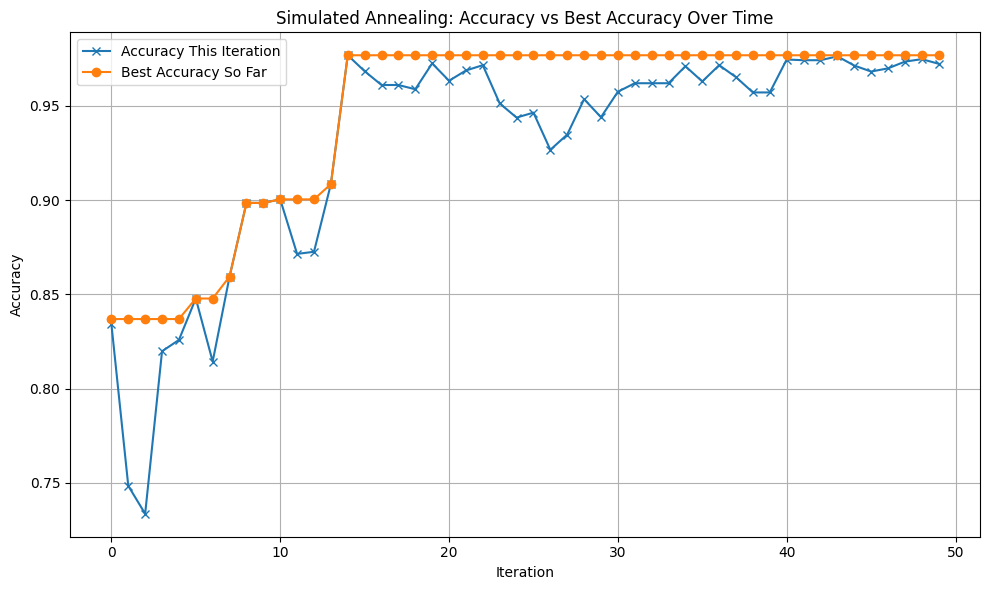

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(accuracy_over_time, label='Accuracy This Iteration', marker='x')
plt.plot(best_over_time, label='Best Accuracy So Far', marker='o')
plt.title('Simulated Annealing: Accuracy vs Best Accuracy Over Time')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

More complex task: 

Now we try with continuous values for dropout and learning rate hyperparameter.

In [ ]:
def random_config():
    return {
        'filters': random.choice([32, 64, 128]),
        'kernel_size': random.choice([3, 5]),
        'dropout': round(random.uniform(0.2, 0.6), 2),  # continuous
        'dense_units': random.choice([64, 128, 256]),
        'optimizer': random.choice(['adam', 'sgd']),
        'learning_rate': round(random.uniform(1e-5, 1e-2), 5)  # continuous
    }


Conclusion thus far:

We have experimented with SA and Random Sampling with a small number of search space: 216.

Next Step:
Experiment with a large search space: 10000?
Then also